# **1) IMPORT LIABRARIES**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# **2**. Upload Datasets For Stock Data And News Headlines


In [4]:
stock_price = pd.read_csv('/content/drive/MyDrive/^BSESN.csv')
stock_headlines = pd.read_csv('/content/drive/MyDrive/india-news-headlines.csv')


# **3. Data Cleaning**


In [5]:
stock_price.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0


In [6]:
stock_headlines.head()


,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [7]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(5043, 3424067)

In [8]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

## `3.2 STOCK TEXTUAL DATA`

In [9]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0
...,...,...,...,...,...
2021-03-01,49849.839844,49747.710938,50058.421875,49440.460938,18400.0
2021-03-02,50296.890625,50258.089844,50439.820313,49807.121094,17500.0
2021-03-03,51444.648438,50738.210938,51539.890625,50512.839844,15800.0


# 3.2. Textual News Headlines Data


In [10]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# Assuming the date column is named 'Date'
# If it's different, replace 'Date' with the actual column name
# Check if the 'date' column exists in your DataFrame
if 'date' in stock_headlines.columns:
    stock_headlines['publish_date'] = stock_headlines['date'].astype(str)
else:
    # Handle case where 'date' column doesn't exist
    # You might need to identify the actual date column name
    # and adjust the code accordingly.
    # For example, if your date column is named 'publish_date':
    stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
    # Or, if your date column is something else, replace with the correct column name.

# If the DataFrame is empty or if the 'date' column doesn't exist,
# print a message to the user and stop the process
if stock_headlines.empty:
    print("Warning: stock_headlines DataFrame is empty.")
    # Handle the empty DataFrame: e.g., raise an exception, load data again, etc.
    raise ValueError("stock_headlines DataFrame is empty. Check your data and filtering.")

# coverting the datatype of column 'Date' from type string to type 'datetime'
# Fixing the date string creation to handle potential errors
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(
    lambda x: pd.to_datetime(x, format='%Y%m%d', errors='coerce').strftime('%Y-%m-%d')
    if len(x) == 8 and x.isdigit() else pd.NaT
)

# Drop rows with invalid dates (NaT)
stock_headlines.dropna(subset=['publish_date'], inplace=True)

# Convert 'publish_date' to datetime
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()


# filtering the important columns required
# Ensure 'headline_text' is a valid column in your original CSV
# If not, replace it with the correct column name
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# Check if stock_headlines is empty after filtering
if stock_headlines.empty:
    print("Warning: stock_headlines DataFrame is empty after filtering.")
    # Handle the empty DataFrame: e.g., raise an exception, load data again, etc.
    raise ValueError("stock_headlines DataFrame is empty. Check your data and filtering.")

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace=True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


# 4. Combine Stock Data


In [11]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2020-12-24,46973.539063,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,47746.218750,47789.031250,47807.851563,47358.359375,15600.0,Numerology Readings 30 December 2020: Predicti...


In [13]:
#alternate way is to use merge funtion and inner join operation
pd.merge(stock_price, stock_headlines, left_index=True, right_index=True, how='inner')

,Close,Open,High,Low,Volume,headline_text
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2020-12-24,46973.539063,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,47746.218750,47789.031250,47807.851563,47358.359375,15600.0,Numerology Readings 30 December 2020: Predicti...


# 5. Sentiment Analysis


In [14]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...,,,,
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [15]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...,0.9253,0.104,0.744,0.152
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


In [17]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# set the index name
stock_data.index.name = 'Date'

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,4018.879883,-0.9621,0.119,0.817,0.064,3953.219971,4028.570068,3929.370117,0.0
2001-01-03,4060.020020,0.6322,0.084,0.817,0.098,3977.580078,4067.659912,3977.580078,0.0
2001-01-04,4115.370117,0.6648,0.077,0.843,0.080,4180.970215,4180.970215,4109.549805,0.0
2001-01-05,4183.729980,0.9253,0.104,0.744,0.152,4116.339844,4195.009766,4115.350098,0.0
2001-01-08,4120.430176,-0.9638,0.119,0.855,0.026,4164.759766,4206.720215,4101.529785,0.0


In [18]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

# 6. Exploratory Data Analysis


In [19]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(4893, 9)

In [20]:
# checking for null values
stock_data.isna().any()

,0
Close,False
compound,False
negative,False
neutral,False
positive,False
Open,False
High,False
Low,False
Volume,False


In [21]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4.893000e+03
mean,18685.761055,-0.877377,0.126786,0.786600,0.086609,18706.141903,18818.841446,18557.102644,8.070914e+04
std,11233.725489,0.441674,0.024094,0.032986,0.020853,11250.819220,11290.044725,11181.713549,1.069967e+06
min,2600.120117,-1.000000,0.000000,0.000000,0.000000,2621.889893,2682.590088,2594.870117,0.000000e+00
25%,8929.440430,-0.999800,0.113000,0.766000,0.076000,8939.379883,9033.990234,8799.009766,9.400000e+03
50%,17618.349609,-0.999200,0.128000,0.783000,0.086000,17650.820313,17769.250000,17500.789063,1.400000e+04
75%,27288.169922,-0.994800,0.142000,0.804000,0.097000,27316.429688,27445.240234,27159.449219,2.080000e+04
max,47751.328125,1.000000,0.444000,1.000000,0.608000,47789.031250,47896.968750,47602.121094,3.181510e+07


In [22]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4893 entries, 2001-01-02 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4893 non-null   float64
 1   compound  4893 non-null   float64
 2   negative  4893 non-null   float64
 3   neutral   4893 non-null   float64
 4   positive  4893 non-null   float64
 5   Open      4893 non-null   float64
 6   High      4893 non-null   float64
 7   Low       4893 non-null   float64
 8   Volume    4893 non-null   float64
dtypes: float64(9)
memory usage: 382.3 KB


Text(0, 0.5, 'Close Price ($)')

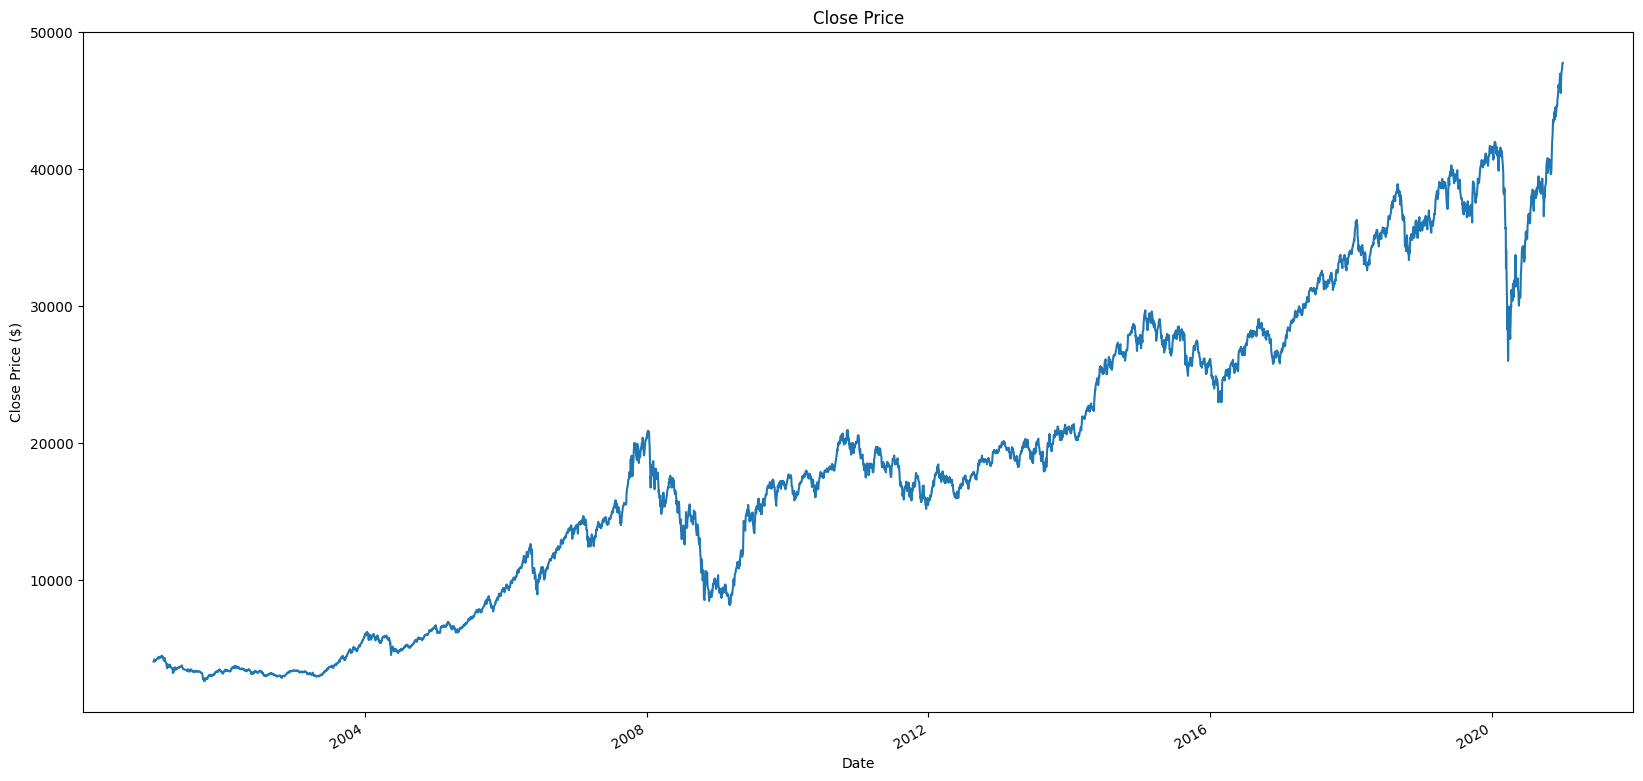

In [23]:
# setting figure size
plt.figure(figsize=(20,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [24]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,4095.911447,-0.175914,0.121571,0.810143,0.068000,4094.170027,4143.089983,4052.832799,0.0
2001-01-23,4135.598598,0.094314,0.109714,0.818286,0.071714,4140.542899,4184.972831,4101.904227,0.0
2001-01-24,4173.655727,-0.125129,0.111429,0.825000,0.063429,4189.532854,4223.794294,4147.351353,0.0


<Axes: xlabel='Date'>

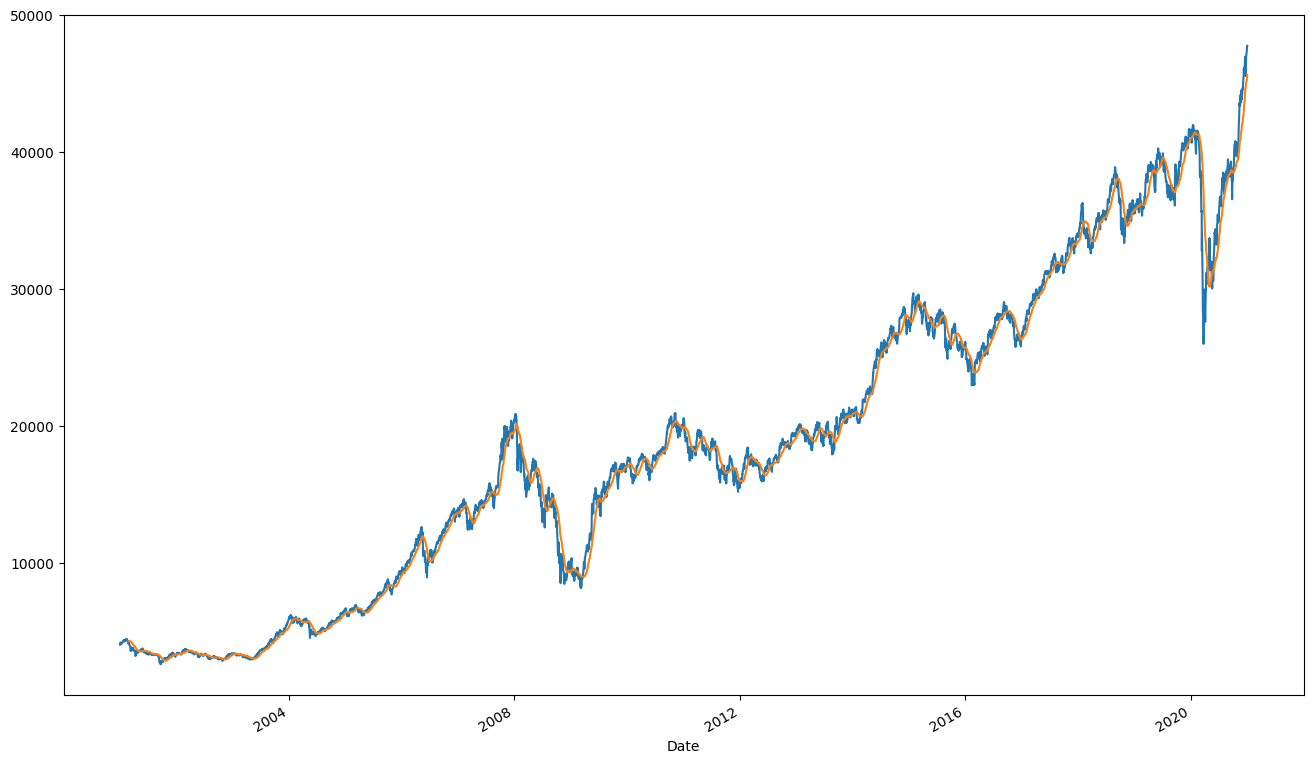

In [25]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

Blue -> Closed Price ,
Orange -> Rolling mean


# 7. Data Preparation


In [34]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3913
Number of records in Test Data: 980


In [35]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
print(close_price)

Close Price:
Date
2001-01-03     4060.020020
2001-01-04     4115.370117
2001-01-05     4183.729980
2001-01-08     4120.430176
2001-01-09     4125.310059
                  ...     
2020-12-24    46973.539063
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
2020-12-31    47751.328125
Name: Close, Length: 4892, dtype: float64


In [36]:
# shifting next day close
close_price_shifted = close_price.shift(-1)

# shifting next day compound
compound_shifted = compound.shift(-1)

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,4060.020020,4115.370117,0.6322,0.6648,0.0,3977.580078,4067.659912,3977.580078
2001-01-04,4115.370117,4183.729980,0.6648,0.9253,0.0,4180.970215,4180.970215,4109.549805
2001-01-05,4183.729980,4120.430176,0.9253,-0.9638,0.0,4116.339844,4195.009766,4115.350098
2001-01-08,4120.430176,4125.310059,-0.9638,-0.9559,0.0,4164.759766,4206.720215,4101.529785
2001-01-09,4125.310059,4047.639893,-0.9559,-0.5719,0.0,4114.740234,4166.839844,4101.009766
2001-01-10,4047.639893,4296.689941,-0.5719,0.9295,0.0,4151.580078,4155.859863,4035.439941
2001-01-23,4296.689941,4326.419922,0.9295,-0.9039,0.0,4277.830078,4321.750000,4272.870117
2001-01-24,4326.419922,4330.220215,-0.9039,-0.9838,0.0,4320.509766,4339.410156,4295.709961
2001-01-25,4330.220215,4234.569824,-0.9838,0.9697,0.0,4327.839844,4341.330078,4273.700195


# 7.1. Setting Target Variable And Feature Dataset




In [37]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

,close_price_shifted
Date,
2001-01-03,4115.370117
2001-01-04,4183.729980
2001-01-05,4120.430176
2001-01-08,4125.310059
2001-01-09,4047.639893
...,...
2020-12-23,46973.539063
2020-12-24,47353.750000
2020-12-28,47613.078125


In [38]:
# setting the features dataset for prediction
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-03,4060.020020,0.6322,0.6648,0.0,3977.580078,4067.659912,3977.580078
2001-01-04,4115.370117,0.6648,0.9253,0.0,4180.970215,4180.970215,4109.549805
2001-01-05,4183.729980,0.9253,-0.9638,0.0,4116.339844,4195.009766,4115.350098
2001-01-08,4120.430176,-0.9638,-0.9559,0.0,4164.759766,4206.720215,4101.529785
2001-01-09,4125.310059,-0.9559,-0.5719,0.0,4114.740234,4166.839844,4101.009766
...,...,...,...,...,...,...,...
2020-12-23,46444.179688,-0.9996,-0.9971,10500.0,46072.300781,46513.320313,45899.101563
2020-12-24,46973.539063,-0.9971,-0.9997,13700.0,46743.488281,47053.398438,46539.019531
2020-12-28,47353.750000,-0.9997,-0.9998,9600.0,47153.589844,47406.718750,47148.238281


# 7.2 Scaling the Target Variable and the Feature Dataset
Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.




In [39]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.93532553,  0.6322    ,  0.6648    , ..., -0.93997007,
         -0.93861222, -0.93822641],
        [-0.93287349,  0.6648    ,  0.9253    , ..., -0.93096396,
         -0.93359019, -0.93233057],
        [-0.92984511,  0.9253    , -0.9638    , ..., -0.93382579,
         -0.93296794, -0.93207144],
        ...,
        [ 0.98261339, -0.9997    , -0.9998    , ...,  0.97186267,
          0.98222136,  0.99045457],
        [ 0.99410179, -0.9998    , -0.9998    , ...,  0.98572369,
          0.99586481,  1.        ],
        [ 1.        , -0.9998    , -0.9996    , ...,  1.        ,
          1.        ,  0.99984189]]),
 array([[-0.93288109],
        [-0.92985305],
        [-0.93265695],
        ...,
        [ 0.99387613],
        [ 0.99977368],
        [ 1.        ]]))

# 7.3. Dividing the dataset into Training and Test
Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.



In [40]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]
y_train = y[0 : train_end]
y_test = y[train_end+1 : len(y)]

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3913, 7) and y: (3913, 1)
Number of rows and columns in the Test set X: (977, 7) and y: (977, 1)


In [41]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3913, 7, 1)
Shape of Test set X: (977, 7, 1)


# 8. Stock Data Modelling


In [42]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 100)              │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,701 (787.89 KB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0713 - val_loss: 0.0255
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0015 - val_loss: 1.7532e-04
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0015 - val_loss: 4.0241e-04
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0011 - val_loss: 7.6591e-04
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0011 - val_loss: 4.1275e-04
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 9.9017e-04 - val_loss: 6.4885e-04
Epoch 9/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0011 - val_loss: 1.6973e-04
Epoch 10/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 8.1462e-04 - val_loss: 3.3467e-04


# 8.1. Saving the Model to disk


In [45]:
# serialize weights to HDF5
model.save_weights('model.weights.h5') # Changed the filename to include the .weights extension.
print('Model is saved to the disk')

Model is saved to the disk


# 9. Model Predictions


In [46]:
# performing predictions
predictions = model.predict(X_test)

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Predictions:


array([[27123.705],
       [27329.422],
       [27482.66 ],
       [27596.49 ],
       [27523.916]], dtype=float32)

# 10. Model Evaluation


In [48]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = {
    "Date": ["2001-01-02", "2001-01-03", "2001-01-04", "2001-01-05", "2001-01-08"],
    "Close": [4018.879883, 4060.020020, 4115.370117, 4183.729980, 4120.430176]
}

# Create DataFrame
df = pd.DataFrame(data)

# Add Predicted Close Prices (replace this with your actual predicted data)
# For demonstration, we'll add a column with slightly varied values from 'Close'
df["Predicted_Close_Price"] = [4020, 4062, 4110, 4180, 4125]  # Replace with your data

# Calculate metrics
mae = mean_absolute_error(df["Close"], df["Predicted_Close_Price"]) # Now mean_absolute_error is defined
mse = mean_squared_error(df["Close"], df["Predicted_Close_Price"])
rmse = np.sqrt(mse)
r2 = r2_score(df["Close"], df["Predicted_Close_Price"])

# Print metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 3.354003600000124
Mean Squared Error (MSE): 13.761836335832049
Root Mean Squared Error (RMSE): 3.7096949114222384
R-squared (R2): 0.9956567322169512


# 11. Plotting the Predictions against unseen data


In [49]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))



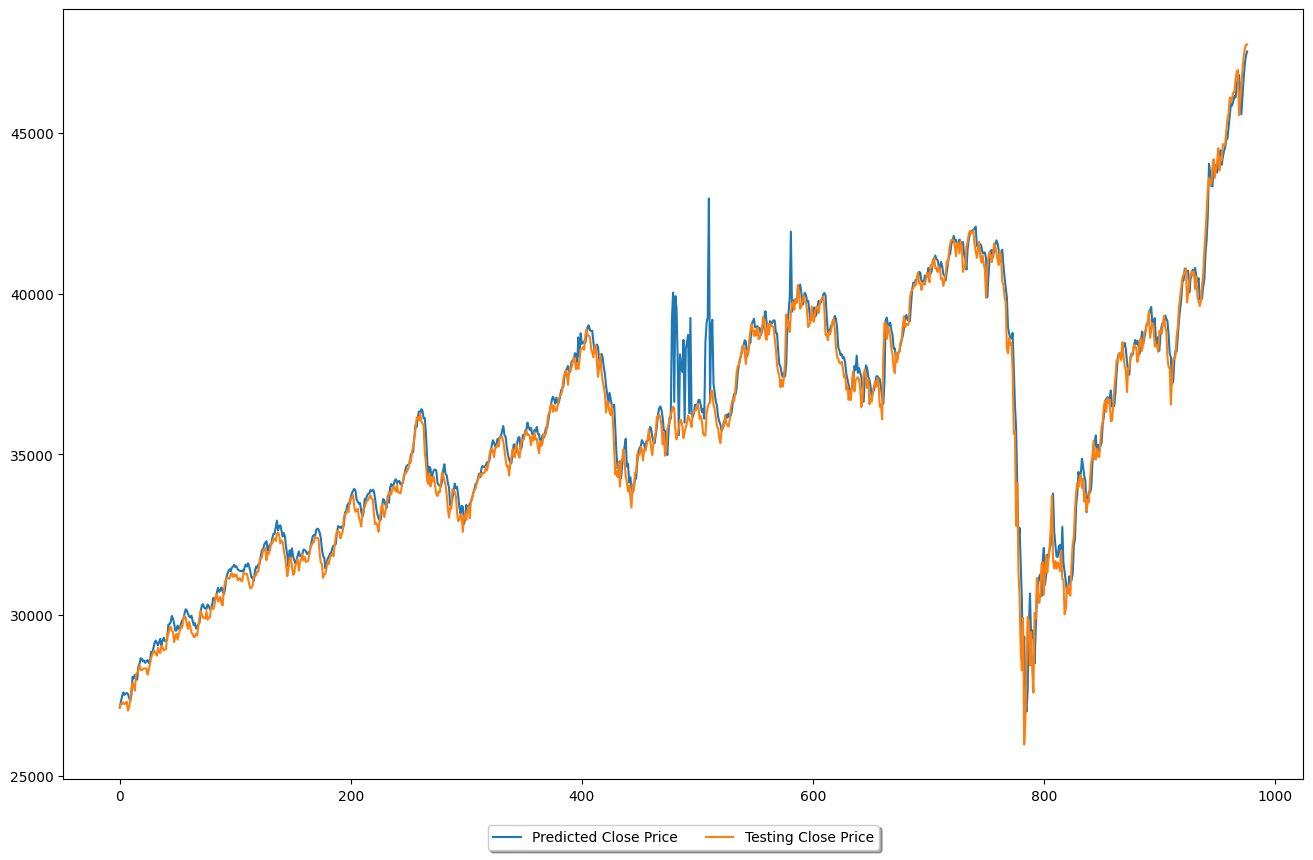

In [50]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [53]:
# Adding empty sentiment columns to stock_data for later calculation
stock_data['polarity'] = ''
stock_data['subjectivity'] = ''

# Importing TextBlob
import pandas as pd
from textblob import TextBlob

# Assuming 'headline_text' still exists in your DataFrame
# If it has been removed, you'll need to reload the data
if 'headline_text' in stock_data.columns: # Changed stock_headlines to stock_data
    stock_data['headline_text'].fillna('', inplace=True)

    # Calculating sentiment scores using TextBlob
    # Changed 'df' to 'stock_data'
    stock_data['polarity'] = stock_data['headline_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    stock_data['subjectivity'] = stock_data['headline_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Drop unnecessary columns
    # 'publish_date' likely already dropped, so only drop 'headline_text'
    stock_data.drop(['headline_text'], axis=1, inplace=True) # Changed stock_headlines to stock_data

# If 'headline_text' was already removed, consider this alternative:
else:
    print("Warning: 'headline_text' column not found. Skipping sentiment analysis.")

# Rearranging the columns
# Ensure the columns you're selecting still exist
stock_data = stock_data[['Close', 'polarity', 'subjectivity', 'Open', 'High', 'Low', 'Volume', 'compound', 'negative', 'neutral', 'positive']] # Changed stock_headlines to stock_data and added other columns from original stock_data

# Setting the index name
stock_data.index.name = 'Date' # Changed stock_headlines to stock_data

# Displaying the final stock_data
print(stock_data.head()) # Changed stock_headlines to stock_data

# Writing the prepared stock_data to disk
stock_data.to_csv('stock_data_with_textblob.csv') # Changed stock_headlines to stock_data

                  Close polarity subjectivity         Open         High  \
Date                                                                      
2001-01-02  4018.879883                        3953.219971  4028.570068   
2001-01-03  4060.020020                        3977.580078  4067.659912   
2001-01-04  4115.370117                        4180.970215  4180.970215   
2001-01-05  4183.729980                        4116.339844  4195.009766   
2001-01-08  4120.430176                        4164.759766  4206.720215   

                    Low  Volume  compound  negative  neutral  positive  
Date                                                                    
2001-01-02  3929.370117     0.0   -0.9621     0.119    0.817     0.064  
2001-01-03  3977.580078     0.0    0.6322     0.084    0.817     0.098  
2001-01-04  4109.549805     0.0    0.6648     0.077    0.843     0.080  
2001-01-05  4115.350098     0.0    0.9253     0.104    0.744     0.152  
2001-01-08  4101.529785     0.0   -0